In [4]:
import os
import re
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import RNN, GRU, LSTM, Dense, Input, Embedding, Dropout, Activation, concatenate
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D,GlobalMaxPool1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
drivePath = "/content/drive/MyDrive/toxic-comments-classification-master/"
train_data = pd.read_csv(drivePath+'train.csv')
test_data = pd.read_csv(drivePath+'test.csv')


In [7]:
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [12]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_data['comment_text'] = test_data['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Preprocess

In [ ]:
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

Inspect data

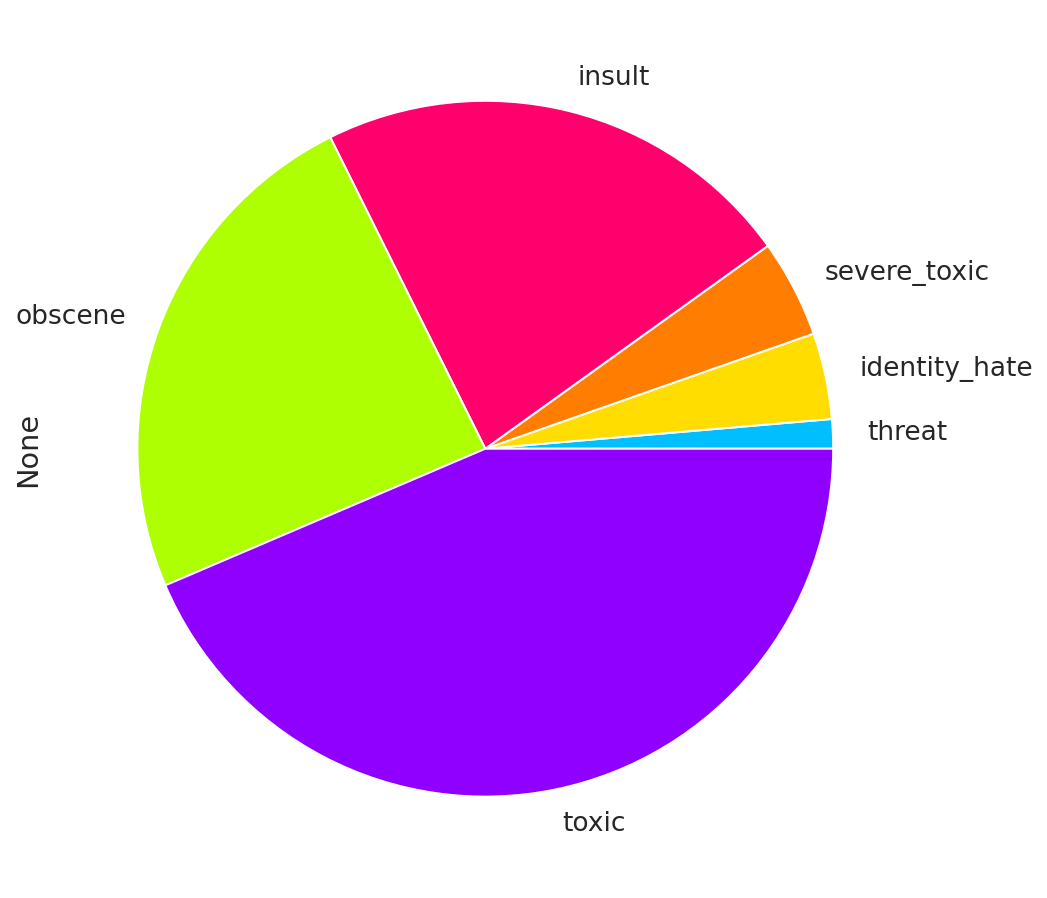

In [14]:
LABEL_COLUMNS = train_data.columns.tolist()[2:]
train_data[LABEL_COLUMNS].sum().sort_values().plot(kind="pie");

In [ ]:
train_data[LABEL_COLUMNS].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Split data

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
train_df, val_df = train_test_split(train_data, test_size=0.1)


Prepare training data

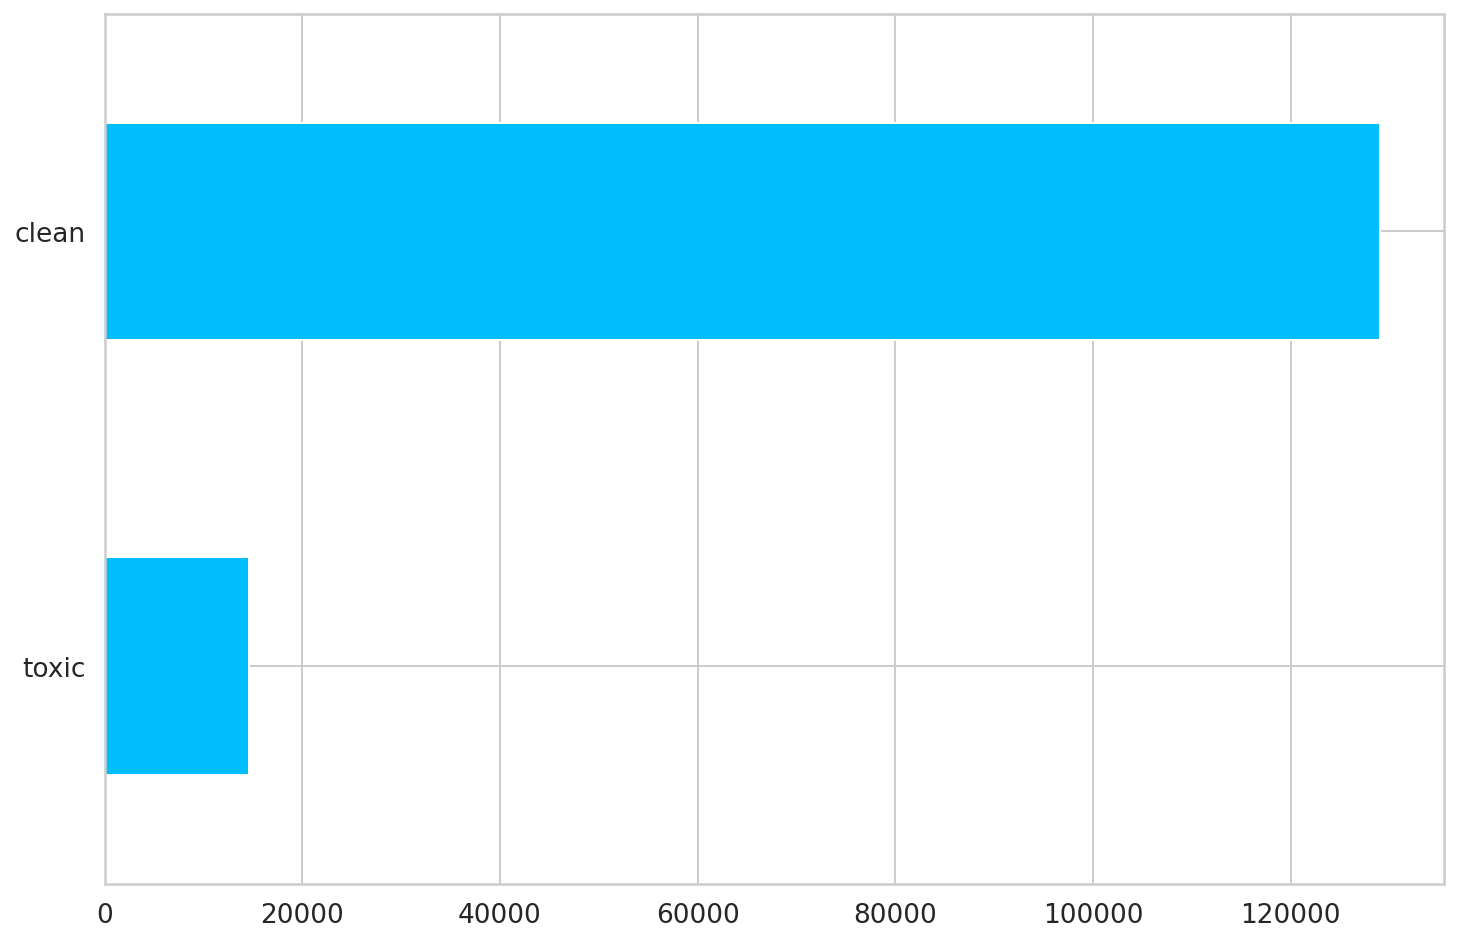

In [17]:
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]
pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean)]
)).iloc[0].plot(kind="barh");



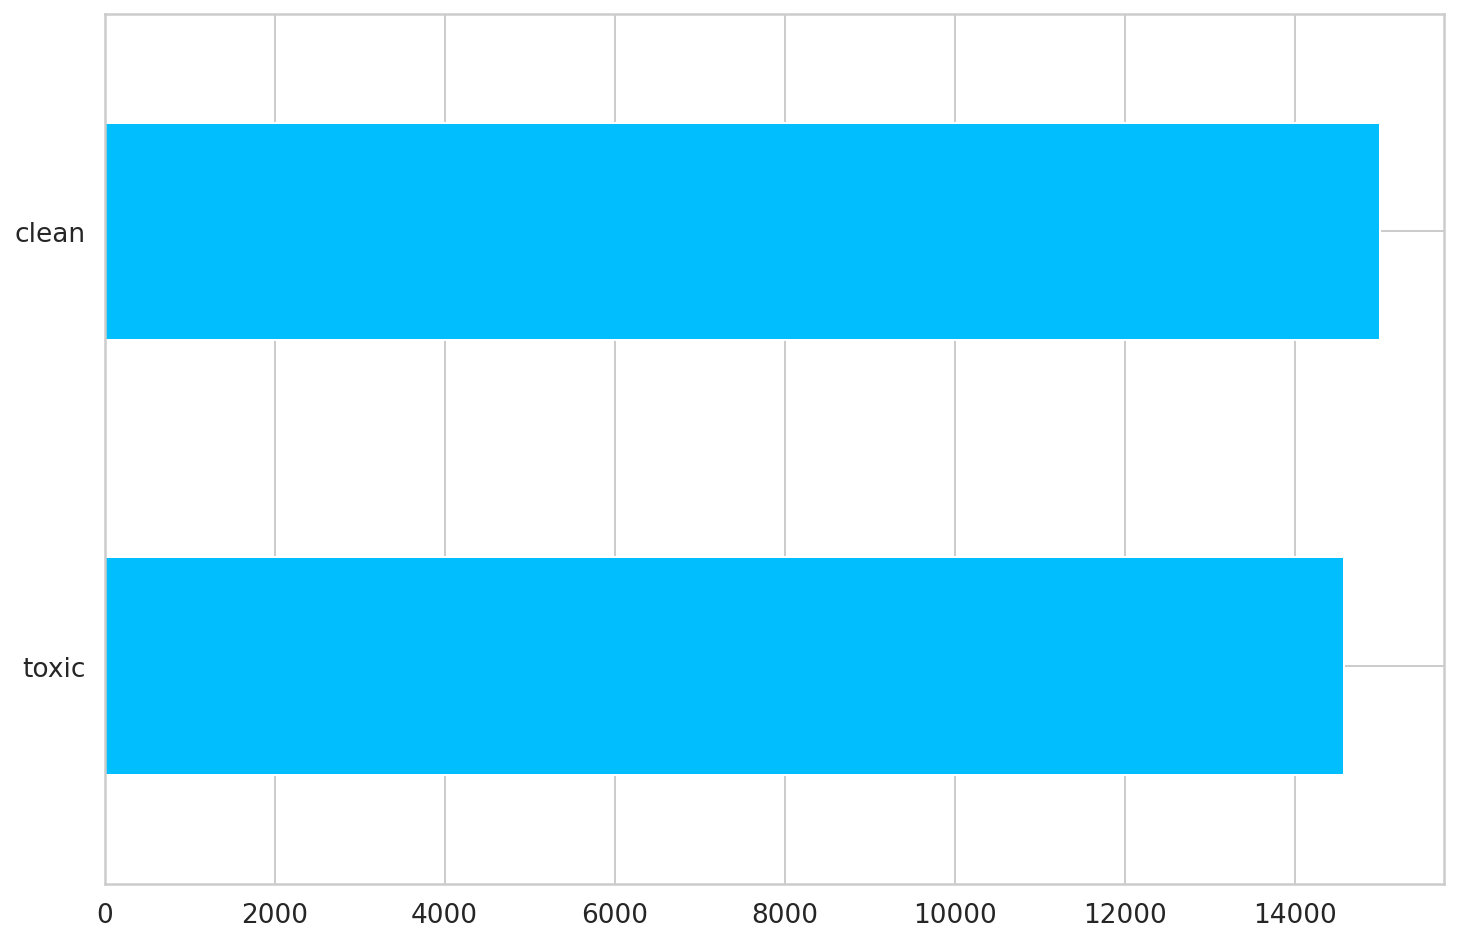

In [18]:
#balancing data
subsample = 15_000
train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]
pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean.sample(subsample))]
)).iloc[0].plot(kind="barh");


train_set = pd.concat([
  train_toxic,
  train_clean.sample(15_000)
])
ytrain_toxic = np.ones((len(train_toxic),1))
ytrain_clean = np.zeros((subsample,1))
y_train_set = np.concatenate((ytrain_toxic, ytrain_clean))

In [19]:
#shuffle data

from sklearn.utils import shuffle

X_train, Y_train = shuffle(train_set, y_train_set)



In [ ]:
X_train.shape, Y_train.shape

((29528, 8), (29528, 1))

Prepare validation data

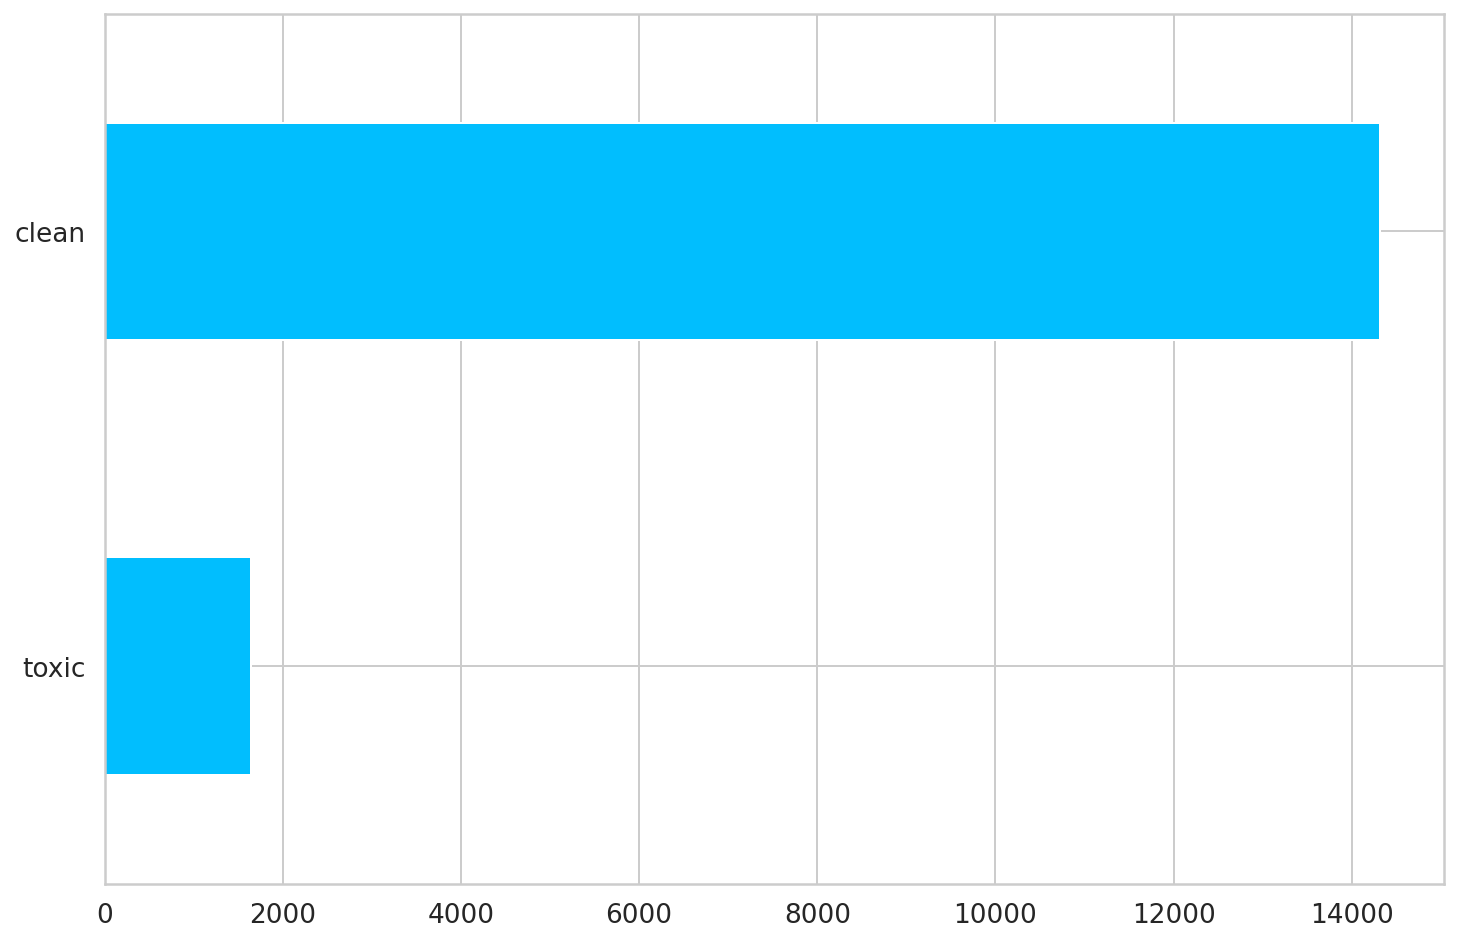

In [20]:
val_toxic = val_df[val_df[LABEL_COLUMNS].sum(axis=1) > 0]
val_clean = val_df[val_df[LABEL_COLUMNS].sum(axis=1) == 0]
pd.DataFrame(dict(
  toxic=[len(val_toxic)], 
  clean=[len(val_clean)]
)).iloc[0].plot(kind="barh");
val_set =  pd.concat([
  val_toxic,
  val_clean
])
yval_toxic = np.ones((len(val_toxic),1))
yval_clean = np.zeros((len(val_clean),1))
y_val_set = np.concatenate((yval_toxic, yval_clean))

In [21]:
X_val, Y_val = shuffle(val_set, y_val_set)

In [ ]:
X_val.shape, Y_val.shape

((15958, 8), (15958, 1))

Done preparing data


In [22]:
max_features = 100000
max_len = 150
embed_size = 300

In [26]:
train_sentences = X_train['comment_text']
val_sentences = X_val['comment_text']

In [27]:
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(list(train_sentences))

In [28]:
tokenizer.word_index

{'i': 1,
 'you': 2,
 'fuck': 3,
 'the': 4,
 'wikipedia': 5,
 'article': 6,
 'page': 7,
 'it': 8,
 'like': 9,
 'talk': 10,
 'this': 11,
 'one': 12,
 'please': 13,
 'if': 14,
 'a': 15,
 'would': 16,
 'and': 17,
 'know': 18,
 'go': 19,
 'shit': 20,
 'people': 21,
 'get': 22,
 'nigger': 23,
 "i'm": 24,
 'think': 25,
 'is': 26,
 'me': 27,
 'see': 28,
 'fucking': 29,
 'also': 30,
 'suck': 31,
 'in': 32,
 'edit': 33,
 'hate': 34,
 'time': 35,
 'are': 36,
 'user': 37,
 'that': 38,
 'your': 39,
 'my': 40,
 'even': 41,
 'want': 42,
 'u': 43,
 'gay': 44,
 'ass': 45,
 'use': 46,
 'make': 47,
 'so': 48,
 'articles': 49,
 'do': 50,
 'die': 51,
 'hi': 52,
 'what': 53,
 'good': 54,
 'wiki': 55,
 'fat': 56,
 'stop': 57,
 'to': 58,
 'may': 59,
 'well': 60,
 'faggot': 61,
 'not': 62,
 'thanks': 63,
 'way': 64,
 'really': 65,
 'here': 66,
 'bitch': 67,
 'say': 68,
 'all': 69,
 'right': 70,
 'yourself': 71,
 'moron': 72,
 'information': 73,
 'edits': 74,
 'going': 75,
 'need': 76,
 'block': 77,
 'there': 7

In [29]:
tokenized_train_sentences = tokenizer.texts_to_sequences(train_sentences)
tokenized_val_sentences = tokenizer.texts_to_sequences(val_sentences)

In [30]:
train_padding = pad_sequences(tokenized_train_sentences, max_len)
val_padding = pad_sequences(tokenized_val_sentences, max_len)

Define model

In [31]:
inp = Input(shape=(max_len, ))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

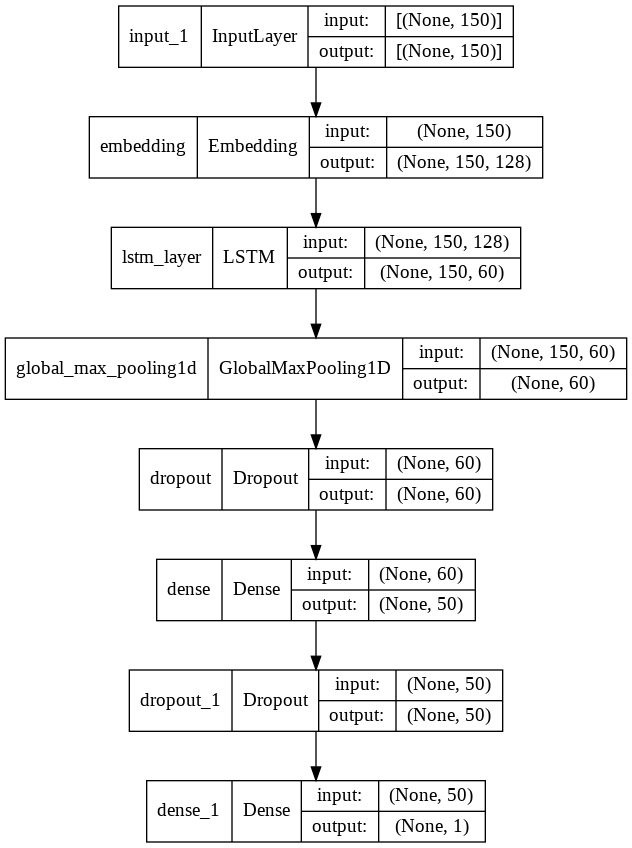

In [ ]:

from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 128)          12800000  
                                                                 
 lstm_layer (LSTM)           (None, 150, 60)           45360     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             

Train model

In [ ]:
batch_size = 32
epochs = 2
history = model.fit(train_padding,Y_train, batch_size=batch_size, epochs=epochs,  validation_data=(val_padding, Y_val))

Epoch 1/2
926/926 [==============================] - 227s 242ms/step - loss: 0.2808 - accuracy: 0.8788 - val_loss: 0.1510 - val_accuracy: 0.9398
Epoch 2/2
926/926 [==============================] - 223s 240ms/step - loss: 0.1334 - accuracy: 0.9497 - val_loss: 0.2707 - val_accuracy: 0.8899


In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def predictToxicContext(context):
  tokenized = tokenizer.texts_to_sequences([context])
  padded_token = pad_sequences(tokenized, max_len)

  return "Probability of toxic context : "+ str(model.predict(padded_token)[0][0]*100)+"%"

In [ ]:
test_sentence = "Son of a bitch motherfucker"

In [ ]:
predictToxicContext(test_sentence)

'Probability of toxic context : 99.98116493225098%'

In [ ]:
from keras.models import load_model

model.save(drivePath+'toxic_classification.h5')  # creates a HDF5 file 'my_model.h5'
import pickle

# saving
with open(drivePath+'tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
